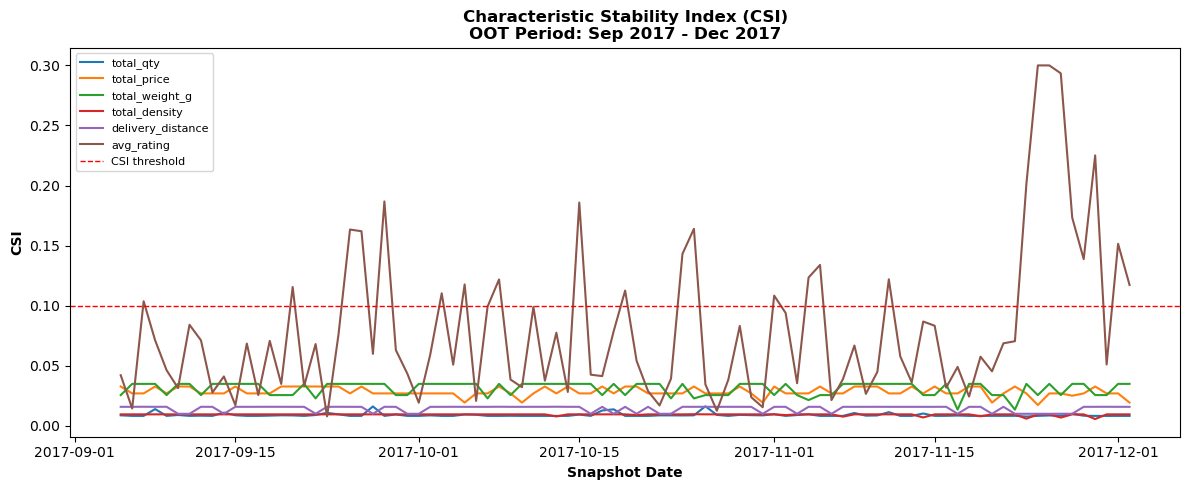

In [85]:
# === Notebook Cell: CSI Over OOT (numerical features only, no season) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
from datetime import datetime

# 1) PARAMETERS
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
ref_start    = datetime(2016, 9, 4).date()
baseline_end = datetime(2017, 9, 4).date()
oot_start    = datetime(2017, 9, 5).date()
oot_end      = datetime(2017, 12, 3).date()

# 2) Features to include (numeric only, no season)
features = [
    "total_qty", "total_price", "total_weight_g", "total_density",
    "delivery_distance", "avg_rating"
]

# 3) Load & tag snapshot_date
records = []
for path in sorted(glob.glob(f"{feat_folder}/*.parquet")):
    m = re.search(r"(\d{4}_\d{2}_\d{2})", path)
    if not m:
        continue
    dt = datetime.strptime(m.group(1), "%Y_%m_%d").date()
    df = pd.read_parquet(path, columns=features).copy()
    df["snapshot_date"] = dt
    records.append(df)

full = pd.concat(records, ignore_index=True)

# 4) Split REF vs OOT
baseline = full[(full.snapshot_date >= ref_start) & (full.snapshot_date <= baseline_end)]
oot      = full[(full.snapshot_date >= oot_start)  & (full.snapshot_date <= oot_end)]

# 5) CSI function for numeric features
def compute_csi(ref_arr, cur_arr, bins=5, epsilon=1e-3):
    if len(cur_arr) == 0 or len(ref_arr) == 0:
        return np.nan
    edges = np.linspace(ref_arr.min(), ref_arr.max(), bins + 1)
    h_ref, _ = np.histogram(ref_arr, edges, density=True)
    h_cur, _ = np.histogram(cur_arr, edges, density=True)
    h_ref = np.where(h_ref == 0, epsilon, h_ref)
    h_cur = np.where(h_cur == 0, epsilon, h_cur)
    return np.sum((h_cur - h_ref) * np.log(h_cur / h_ref))

# 6) Compute CSI per feature per day
dates = pd.date_range(oot_start, oot_end).date
csi = {feat: [] for feat in features}

for d in dates:
    today = oot[oot.snapshot_date == d]
    for feat in features:
        csi[feat].append(
            compute_csi(
                baseline[feat].dropna().values,
                today[feat].dropna().values,
                bins=5
            )
        )

csi_df = pd.DataFrame(csi, index=dates)

# 7) Optional: clip for presentation
csi_df_clipped = csi_df.clip(upper=0.3)

# 8) Plot numerical features only
fig, ax = plt.subplots(figsize=(12, 5))
for feat in features:
    ax.plot(csi_df_clipped.index, csi_df_clipped[feat], label=feat)

ax.axhline(0.1, color="red", linestyle="--", linewidth=1, label="CSI threshold")
ax.set_title("Characteristic Stability Index (CSI)\nOOT Period: Sep 2017 - Dec 2017", fontweight='bold')
ax.set_xlabel("Snapshot Date", fontweight='bold')
ax.set_ylabel("CSI", fontweight='bold')
ax.legend(fontsize=8, frameon=True)
plt.tight_layout()
plt.show()

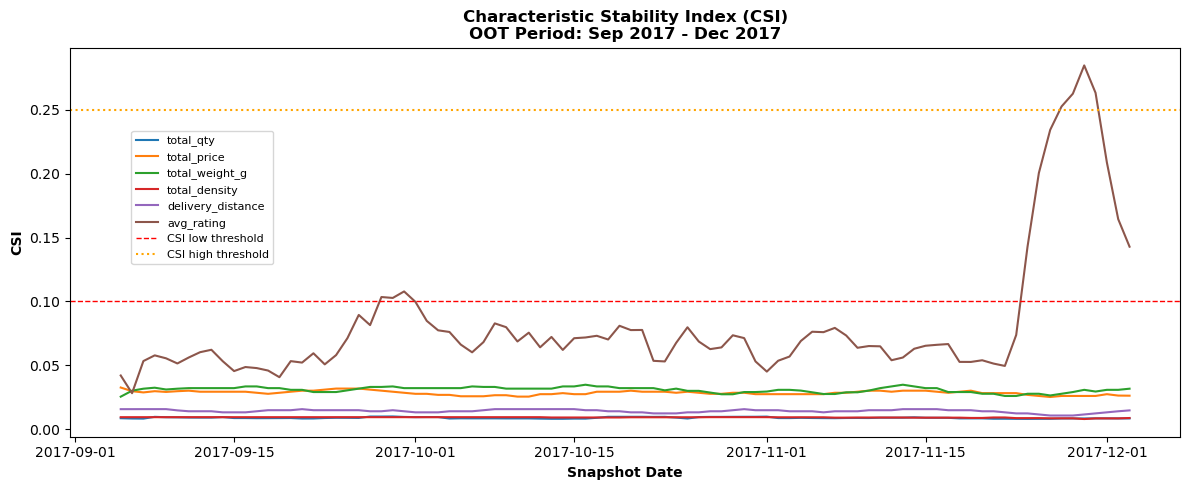

In [87]:
# === Notebook Cell: CSI Over OOT (numerical features only, smoothed + clipped) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
from datetime import datetime

# 1) PARAMETERS
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
ref_start    = datetime(2016, 9, 4).date()
baseline_end = datetime(2017, 9, 4).date()
oot_start    = datetime(2017, 9, 5).date()
oot_end      = datetime(2017, 12, 3).date()

# 2) Features to include (numeric only)
features = [
    "total_qty", "total_price", "total_weight_g", "total_density",
    "delivery_distance", "avg_rating"
]

# 3) Load & tag snapshot_date
records = []
for path in sorted(glob.glob(f"{feat_folder}/*.parquet")):
    m = re.search(r"(\d{4}_\d{2}_\d{2})", path)
    if not m:
        continue
    dt = datetime.strptime(m.group(1), "%Y_%m_%d").date()
    df = pd.read_parquet(path, columns=features).copy()
    df["snapshot_date"] = dt
    records.append(df)

full = pd.concat(records, ignore_index=True)

# 4) Split REF vs OOT
baseline = full[(full.snapshot_date >= ref_start) & (full.snapshot_date <= baseline_end)]
oot      = full[(full.snapshot_date >= oot_start)  & (full.snapshot_date <= oot_end)]

# 5) CSI function for numeric features
def compute_csi(ref_arr, cur_arr, bins=5, epsilon=1e-3):
    if len(cur_arr) == 0 or len(ref_arr) == 0:
        return np.nan
    edges = np.linspace(ref_arr.min(), ref_arr.max(), bins + 1)
    h_ref, _ = np.histogram(ref_arr, edges, density=True)
    h_cur, _ = np.histogram(cur_arr, edges, density=True)
    h_ref = np.where(h_ref == 0, epsilon, h_ref)
    h_cur = np.where(h_cur == 0, epsilon, h_cur)
    return np.sum((h_cur - h_ref) * np.log(h_cur / h_ref))

# 6) Compute CSI per feature per day
dates = pd.date_range(oot_start, oot_end).date
csi = {feat: [] for feat in features}

for d in dates:
    today = oot[oot.snapshot_date == d]
    for feat in features:
        csi[feat].append(
            compute_csi(
                baseline[feat].dropna().values,
                today[feat].dropna().values,
                bins=5
            )
        )

csi_df = pd.DataFrame(csi, index=dates)

# 7) Apply smoothing (rolling average) and clipping
csi_df_smoothed = csi_df.rolling(window=7, min_periods=1).mean()
csi_df_clipped = csi_df_smoothed.clip(upper=0.3)

# 8) Plot numerical features only (smoothed + clipped)
fig, ax = plt.subplots(figsize=(12, 5))
for feat in features:
    ax.plot(csi_df_clipped.index, csi_df_clipped[feat], label=feat)

ax.axhline(0.1, color="red", linestyle="--", linewidth=1, label="CSI low threshold")
ax.axhline(0.25, color="orange", linestyle=":", linewidth=1.5, label="CSI high threshold")
ax.set_title("Characteristic Stability Index (CSI)\nOOT Period: Sep 2017 - Dec 2017", fontweight='bold')
ax.set_xlabel("Snapshot Date", fontweight='bold')
ax.set_ylabel("CSI", fontweight='bold')
ax.legend(
    fontsize=8,
    frameon=True,
    bbox_to_anchor=(0.05, 0.8),  # adjust vertical position here
    loc="upper left"
)
plt.tight_layout()
plt.show()

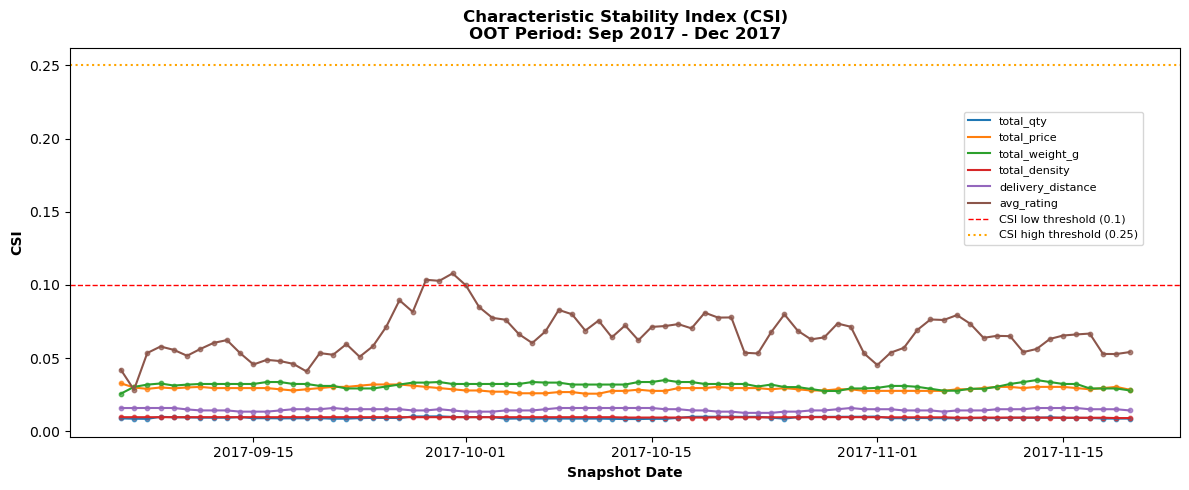

In [2]:
# === Notebook Cell: CSI Over OOT (numerical, smoothed, clipped, with visible markers) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
from datetime import datetime

# 1) PARAMETERS
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
ref_start    = datetime(2016, 9, 4).date()
baseline_end = datetime(2017, 9, 4).date()
oot_start    = datetime(2017, 9, 5).date()
oot_end      = datetime(2017, 11, 20).date()

# 2) Features (numerical only)
features = [
    "total_qty", "total_price", "total_weight_g", "total_density",
    "delivery_distance", "avg_rating"
]

# 3) Load & tag snapshot_date
records = []
for path in sorted(glob.glob(f"{feat_folder}/*.parquet")):
    m = re.search(r"(\d{4}_\d{2}_\d{2})", path)
    if not m:
        continue
    dt = datetime.strptime(m.group(1), "%Y_%m_%d").date()
    df = pd.read_parquet(path, columns=features).copy()
    df["snapshot_date"] = dt
    records.append(df)

full = pd.concat(records, ignore_index=True)

# 4) Split REF and OOT
baseline = full[(full.snapshot_date >= ref_start) & (full.snapshot_date <= baseline_end)]
oot      = full[(full.snapshot_date >= oot_start)  & (full.snapshot_date <= oot_end)]

# 5) CSI function
def compute_csi(ref_arr, cur_arr, bins=5, epsilon=1e-3):
    if len(cur_arr) == 0 or len(ref_arr) == 0:
        return np.nan
    edges = np.linspace(ref_arr.min(), ref_arr.max(), bins + 1)
    h_ref, _ = np.histogram(ref_arr, edges, density=True)
    h_cur, _ = np.histogram(cur_arr, edges, density=True)
    h_ref = np.where(h_ref == 0, epsilon, h_ref)
    h_cur = np.where(h_cur == 0, epsilon, h_cur)
    return np.sum((h_cur - h_ref) * np.log(h_cur / h_ref))

# 6) Compute CSI per day
dates = pd.date_range(oot_start, oot_end).date
csi = {feat: [] for feat in features}
for d in dates:
    today = oot[oot.snapshot_date == d]
    for feat in features:
        csi[feat].append(
            compute_csi(
                baseline[feat].dropna().values,
                today[feat].dropna().values,
                bins=5
            )
        )
csi_df = pd.DataFrame(csi, index=dates)

# 7) Smoothing + clipping
csi_df_smoothed = csi_df.rolling(window=7, min_periods=1).mean()
csi_df_clipped = csi_df_smoothed.clip(upper=0.3)

# 8) Plot with markers
fig, ax = plt.subplots(figsize=(12, 5))
colors = plt.cm.tab10.colors  # Use distinct matplotlib color cycle

for i, feat in enumerate(features):
    ax.plot(
        csi_df_clipped.index,
        csi_df_clipped[feat],
        label=feat,
        color=colors[i % len(colors)],
        linewidth=1.5
    )
    ax.scatter(
        csi_df_clipped.index,
        csi_df_clipped[feat],
        color=colors[i % len(colors)],
        s=10,
        alpha=0.7
    )

# Reference lines
ax.axhline(0.1, color="red", linestyle="--", linewidth=1, label="CSI low threshold (0.1)")
ax.axhline(0.25, color="orange", linestyle=":", linewidth=1.5, label="CSI high threshold (0.25)")

# Formatting
ax.set_title("Characteristic Stability Index (CSI)\nOOT Period: Sep 2017 - Dec 2017", fontweight='bold')
ax.set_xlabel("Snapshot Date", fontweight='bold')
ax.set_ylabel("CSI", fontweight='bold')
ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(0.8, 0.85), loc="upper left")

plt.tight_layout()
plt.show()

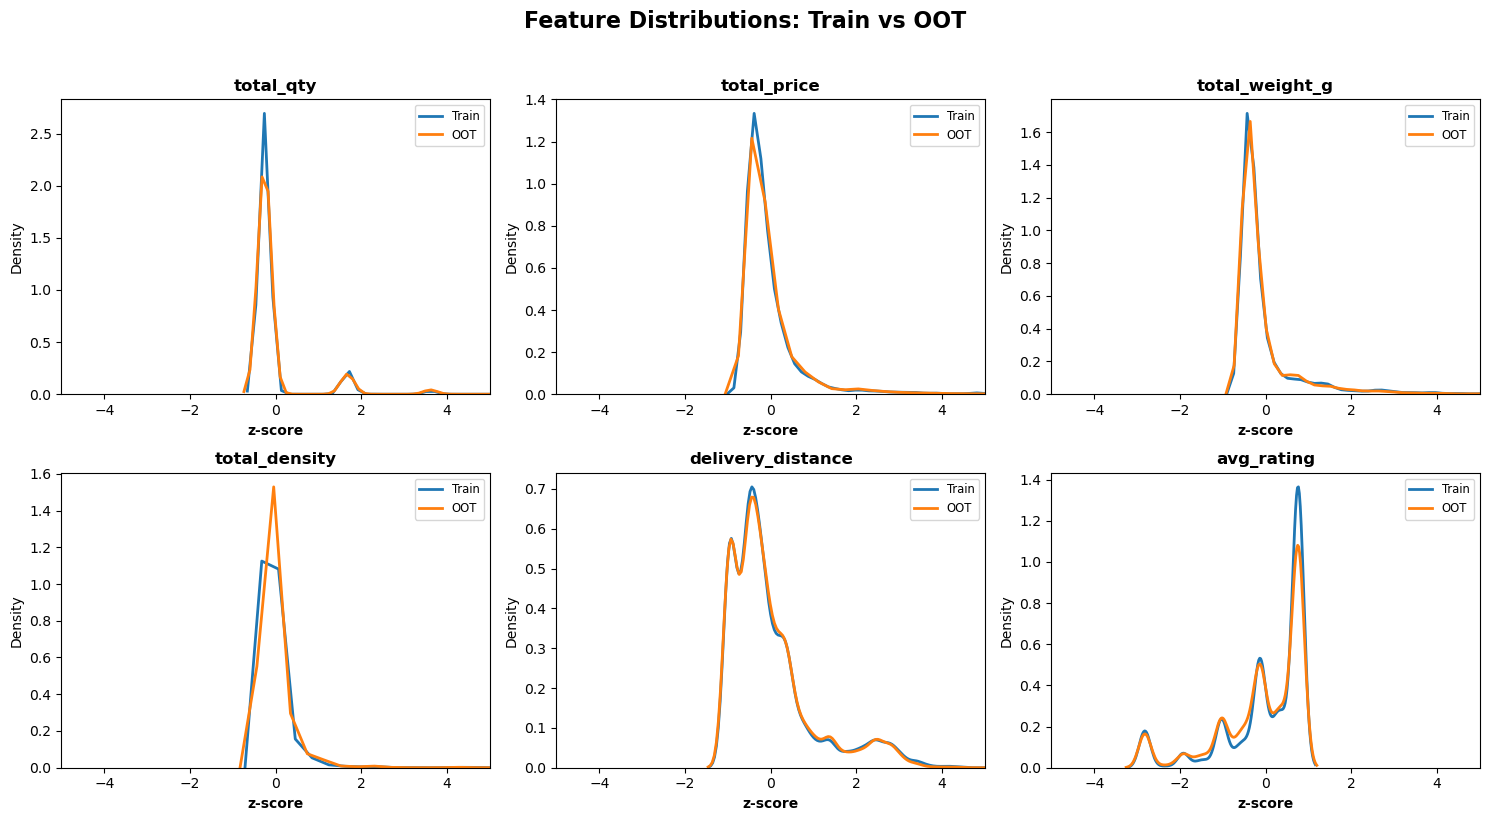

In [77]:
# === Notebook cell: Zero-Centered Density Comparison (z-scores w.r.t. REF), x-axis fixed at [-10,10] ===

import glob, re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns       # for kdeplot

# 1) PARAMETERS
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
ref_start    = datetime(2016, 9, 4).date()
baseline_end = datetime(2017, 9, 4).date()
oot_start    = datetime(2017, 9, 5).date()
oot_end      = datetime(2017, 12, 3).date()
features     = [
    "total_qty", "total_price", "total_weight_g", "total_density",
    "delivery_distance", "avg_rating"
]

# 2) Load & tag snapshot_date
records = []
for path in sorted(glob.glob(f"{feat_folder}/*.parquet")):
    m = re.search(r"(\d{4}_\d{2}_\d{2})", path)
    if not m:
        continue
    dt = datetime.strptime(m.group(1), "%Y_%m_%d").date()
    df = pd.read_parquet(path, columns=features).copy()
    df["snapshot_date"] = dt
    records.append(df)
full = pd.concat(records, ignore_index=True)

# 3) Split REF vs OOT
ref = full[(full.snapshot_date >= ref_start) & (full.snapshot_date <= baseline_end)]
oot = full[(full.snapshot_date >= oot_start)  & (full.snapshot_date <= oot_end)]

# 4) Compute REF mean & std, then create z-score columns
means = ref[features].mean()
stds  = ref[features].std().replace(0, 1.0)

for feat in features:
    full[f"{feat}_z"] = (full[feat] - means[feat]) / stds[feat]

# re-split for plotting
ref_z = full[(full.snapshot_date >= ref_start) & (full.snapshot_date <= baseline_end)]
oot_z = full[(full.snapshot_date >= oot_start) & (full.snapshot_date <= oot_end)]

# 5) Plot densities with fixed x-axis limits
n    = len(features)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    zcol = f"{feat}_z"
    sns.kdeplot(ref_z[zcol].dropna(), ax=ax, label="Train", color="C0", linewidth=2)
    sns.kdeplot(oot_z[zcol].dropna(), ax=ax, label="OOT", color="C1", linewidth=2)

    ax.set_title(feat, fontweight="bold")
    ax.set_xlabel("z-score", fontweight="bold")
    ax.legend(fontsize="small")

    # fixed symmetric x-axis
    ax.set_xlim(-5, 5)

# remove empty subplots
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(
    "Feature Distributions: Train vs OOT",
    y=1.02, fontsize=16, weight="bold"
)
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-

OOT ROC AUC: 0.6906
Overall PSI (REF→OOT): 3.7714


/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-

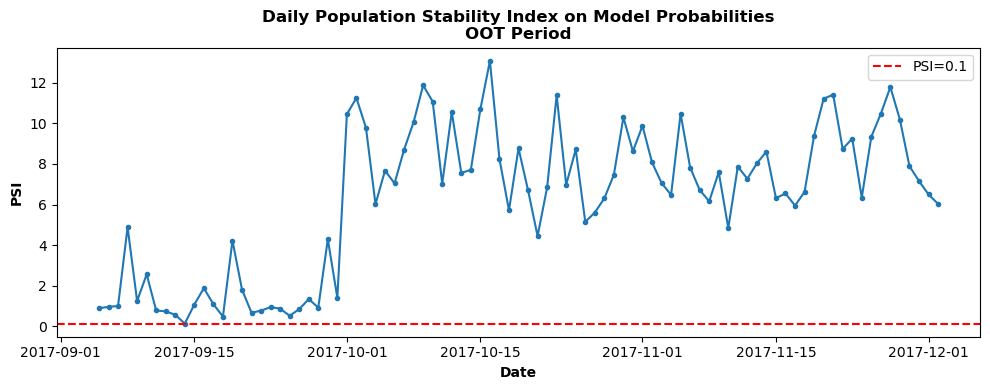

In [82]:
# === Notebook Cell: Prediction-Drift Monitoring via PSI (encoder fitted globally) ===

import glob, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

# 1) CONFIG
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
label_folder = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/label_store"
model_pkl    = "/Users/paulineng/MLE_grp10/scripts/model_bank/xgb_2017_12_04.pkl"

ref_start, ref_end = datetime(2016,9,4), datetime(2017,9,4)
oot_start, oot_end = datetime(2017,9,5), datetime(2017,12,3)

# 2) Load & tag snapshot_date
def load_gold(folder):
    parts = []
    for path in sorted(glob.glob(f"{folder}/*.parquet")):
        fn = path.rsplit("/",1)[-1]
        m  = re.search(r"(\d{4}_\d{2}_\d{2})", fn)
        if not m: continue
        dt = datetime.strptime(m.group(1), "%Y_%m_%d")
        df = pd.read_parquet(path)
        df["snapshot_date"] = dt
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

features = load_gold(feat_folder)
labels   = load_gold(label_folder)

# 3) Identify label column
lbl_cols = [c for c in labels.columns if c not in ("order_id","snapshot_date")]
assert len(lbl_cols)==1, f"Expected one label, got {lbl_cols}"
label_col = lbl_cols[0]

# 4) Split REF / OOT
feat_ref = features[(features.snapshot_date >= ref_start) & (features.snapshot_date <= ref_end)]
feat_oot = features[(features.snapshot_date >= oot_start) & (features.snapshot_date <= oot_end)]
lab_ref  = labels  [(labels.snapshot_date    >= ref_start) & (labels.snapshot_date    <= ref_end)]
lab_oot  = labels  [(labels.snapshot_date    >= oot_start) & (labels.snapshot_date    <= oot_end)]

# 5) Fit OHE on full seasons so both splits get same columns
season_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
season_ohe.fit(features[["season"]])
ohe_cols = season_ohe.get_feature_names_out(["season"])

# 6) Prepare function that merges, drops and applies the **same** encoder
def prepare(df_feat, df_lab):
    df = df_feat.merge(
        df_lab[["order_id","snapshot_date", label_col]],
        on=["order_id","snapshot_date"], how="inner"
    )
    to_drop = [
      "avg_delay_rate","concentration","act_days_to_deliver",
      "total_freight_value","avg_processing_time",
      "same_state","total_volume_cm3","seller_city","seller_state",
      "order_status", label_col
    ]
    X = df.drop(columns=to_drop, errors="ignore").reset_index(drop=True)
    y = df[label_col].astype(int).reset_index(drop=True)

    # transform all at once with the GLOBAL encoder
    S = season_ohe.transform(X[["season"]])
    X = pd.concat([
        X.drop(columns=["season"]),
        pd.DataFrame(S, columns=ohe_cols, index=X.index)
    ], axis=1)
    return X, y

X_ref, y_ref = prepare(feat_ref, lab_ref)
X_oot, y_oot = prepare(feat_oot, lab_oot)

# 7) Load model & scaler
with open(model_pkl, 'rb') as f:
    art    = pickle.load(f)
model     = art["model"]
scaler    = art["preprocessing_transformers"]["stdscaler"]
threshold = art["threshold"]

# 8) Force exact 12-feature order
feature_cols = [
    "total_qty","total_price","total_weight_g","total_density",
    "delivery_distance","same_city","is_weekend","avg_rating",
    "day_of_week","season_Spring","season_Summer","season_Winter"
]
X_ref = X_ref[feature_cols]
X_oot = X_oot[feature_cols]

assert X_ref.shape[1] == scaler.n_features_in_, \
       f"Scaler expects {scaler.n_features_in_}, got {X_ref.shape[1]}"

# 9) Predict probabilities
probs_ref = model.predict_proba(scaler.transform(X_ref))[:,1]
probs_oot = model.predict_proba(scaler.transform(X_oot))[:,1]

# 10) ROC AUC on OOT
print(f"OOT ROC AUC: {roc_auc_score(y_oot, probs_oot):.4f}")

# 11) Overall PSI on model proba
def psi(ref, cur, bins=10):
    edges = np.linspace(ref.min(), ref.max(), bins+1)
    h1,_  = np.histogram(ref, edges, density=True)
    h2,_  = np.histogram(cur, edges, density=True)
    h1[h1==0] = 1e-8
    h2[h2==0] = 1e-8
    return np.sum((h2-h1)*np.log(h2/h1))

# … everything up to step 10 is unchanged …

# 11) Compute overall PSI
print(f"Overall PSI (REF→OOT): {psi(probs_ref, probs_oot):.4f}")

# 12) DAILY PSI: re-prepare each day’s slice so indices match
daily_dates = pd.date_range(oot_start, oot_end)
daily_psi   = []
for d in daily_dates:
    # grab that day’s feature & label rows
    df_feat_day = feat_oot[feat_oot.snapshot_date == d]
    df_lab_day  = lab_oot [lab_oot.snapshot_date  == d]
    if df_feat_day.empty:
        daily_psi.append(np.nan)
    else:
        X_day, _  = prepare(df_feat_day, df_lab_day)
        X_day     = X_day[feature_cols]
        probs_day = model.predict_proba(scaler.transform(X_day))[:,1]
        daily_psi.append(psi(probs_ref, probs_day))

# 13) Plot it
plt.figure(figsize=(10,4))
plt.plot(daily_dates, daily_psi, marker='o', ms=3)
plt.axhline(0.1, color='red', ls='--', label='PSI=0.1')
plt.title("Daily Population Stability Index on Model Probabilities\nOOT Period", weight='bold')
plt.xlabel("Date", weight='bold')
plt.ylabel("PSI",  weight='bold')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


OOT ROC AUC: 0.6906
Overall PSI (REF→OOT): 3.7714


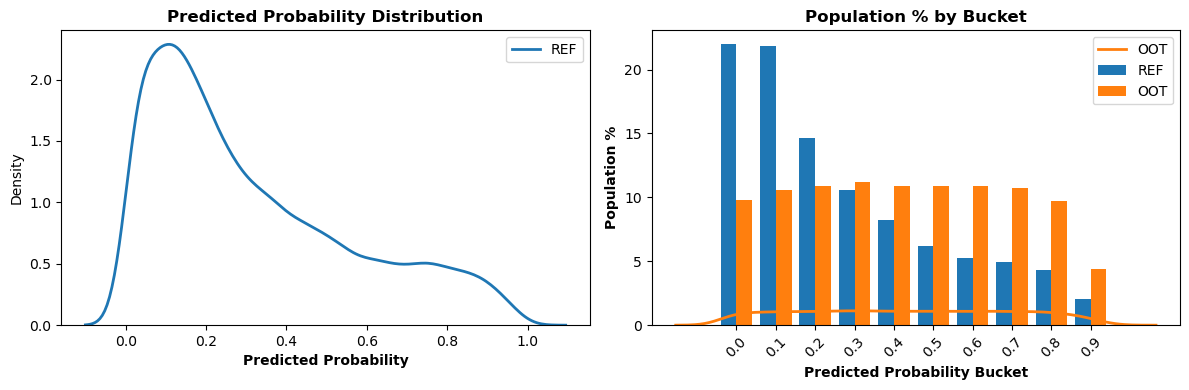

In [18]:
# === Notebook Cell: Prediction-Drift Monitoring via PSI (encoder fitted globally + distribution comparison) ===

import glob, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

# 1) CONFIG
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
label_folder = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/label_store"
model_pkl    = "/Users/paulineng/MLE_grp10/scripts/model_bank/xgb_2017_12_04.pkl"
ref_start, ref_end = datetime(2016,9,4),   datetime(2017,9,4)
oot_start, oot_end = datetime(2017,9,5), datetime(2017,12,3)

# 2) Load & tag snapshot_date
def load_gold(folder):
    parts = []
    for path in sorted(glob.glob(f"{folder}/*.parquet")):
        fn = path.rsplit("/",1)[-1]
        m  = re.search(r"(\d{4}_\d{2}_\d{2})", fn)
        if not m: continue
        dt = datetime.strptime(m.group(1), "%Y_%m_%d")
        df = pd.read_parquet(path)
        df["snapshot_date"] = dt
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

features = load_gold(feat_folder)
labels   = load_gold(label_folder)

# 3) Identify label column
lbl_cols = [c for c in labels.columns if c not in ("order_id","snapshot_date")]
assert len(lbl_cols)==1, f"Expected one label, got {lbl_cols}"
label_col = lbl_cols[0]

# 4) Split REF / OOT
feat_ref = features[(features.snapshot_date >= ref_start) & (features.snapshot_date <= ref_end)]
feat_oot = features[(features.snapshot_date >= oot_start) & (features.snapshot_date <= oot_end)]
lab_ref  = labels  [(labels.snapshot_date   >= ref_start) & (labels.snapshot_date   <= ref_end)]
lab_oot  = labels  [(labels.snapshot_date   >= oot_start) & (labels.snapshot_date   <= oot_end)]

# 5) Fit OHE on full seasons so both splits get same columns
season_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
season_ohe.fit(features[["season"]])
ohe_cols = season_ohe.get_feature_names_out(["season"])

# 6) Prepare function that merges, drops and applies the **same** encoder
def prepare(df_feat, df_lab):
    df = df_feat.merge(
        df_lab[["order_id","snapshot_date", label_col]],
        on=["order_id","snapshot_date"], how="inner"
    )
    to_drop = [
      "avg_delay_rate","concentration","act_days_to_deliver",
      "total_freight_value","avg_processing_time",
      "same_state","total_volume_cm3","seller_city","seller_state",
      "order_status", label_col
    ]
    X = df.drop(columns=to_drop, errors="ignore").reset_index(drop=True)
    y = df[label_col].astype(int).reset_index(drop=True)

    S = season_ohe.transform(X[["season"]])
    X = pd.concat([
        X.drop(columns=["season"]),
        pd.DataFrame(S, columns=ohe_cols, index=X.index)
    ], axis=1)
    return X, y

X_ref, y_ref = prepare(feat_ref, lab_ref)
X_oot, y_oot = prepare(feat_oot, lab_oot)

# 7) Load model & scaler
with open(model_pkl, 'rb') as f:
    art    = pickle.load(f)
model     = art["model"]
scaler    = art["preprocessing_transformers"]["stdscaler"]
threshold = art["threshold"]

# 8) Force exact 12-feature order
feature_cols = [
    "total_qty","total_price","total_weight_g","total_density",
    "delivery_distance","same_city","is_weekend","avg_rating",
    "day_of_week","season_Spring","season_Summer","season_Winter"
]
X_ref = X_ref[feature_cols]
X_oot = X_oot[feature_cols]

assert X_ref.shape[1] == scaler.n_features_in_, \
       f"Scaler expects {scaler.n_features_in_}, got {X_ref.shape[1]}"

# 9) Predict probabilities
probs_ref = model.predict_proba(scaler.transform(X_ref))[:,1]
probs_oot = model.predict_proba(scaler.transform(X_oot))[:,1]

# 10) ROC AUC on OOT
print(f"OOT ROC AUC: {roc_auc_score(y_oot, probs_oot):.4f}")

# 11) Overall PSI on model proba
def psi(ref, cur, bins=10):
    edges = np.linspace(ref.min(), ref.max(), bins+1)
    h1,_  = np.histogram(ref, edges, density=True)
    h2,_  = np.histogram(cur, edges, density=True)
    h1[h1==0] = 1e-8
    h2[h2==0] = 1e-8
    return np.sum((h2-h1)*np.log(h2/h1))

print(f"Overall PSI (REF→OOT): {psi(probs_ref, probs_oot):.4f}")

# ——— 12) Distribution Comparison ———
# build common bins 0→1
bins = np.linspace(0,1,11)

# density subplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

sns.kdeplot(probs_ref, ax=ax1, label="REF", color="C0", linewidth=2)
sns.kdeplot(probs_oot, ax=ax2, label="OOT", color="C1", linewidth=2)
ax1.set_title("Predicted Probability Distribution", weight="bold")
ax1.set_xlabel("Predicted Probability", weight="bold")
ax1.legend()

# bucketed population % subplot
ref_counts, _ = np.histogram(probs_ref, bins=bins)
oot_counts, _ = np.histogram(probs_oot, bins=bins)
ref_pct = ref_counts / len(probs_ref) * 100
oot_pct = oot_counts / len(probs_oot) * 100

width = (bins[1]-bins[0])*0.4
ax2.bar(bins[:-1]+width/2,  ref_pct, width=width, label="REF", color="C0")
ax2.bar(bins[:-1]+1.5*width, oot_pct, width=width, label="OOT", color="C1")
ax2.set_title("Population % by Bucket", weight="bold")
ax2.set_xlabel("Predicted Probability Bucket", weight="bold")
ax2.set_ylabel("Population %", weight="bold")
ax2.set_xticks(bins[:-1] + width)
ax2.set_xticklabels([f"{b:.1f}" for b in bins[:-1]], rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

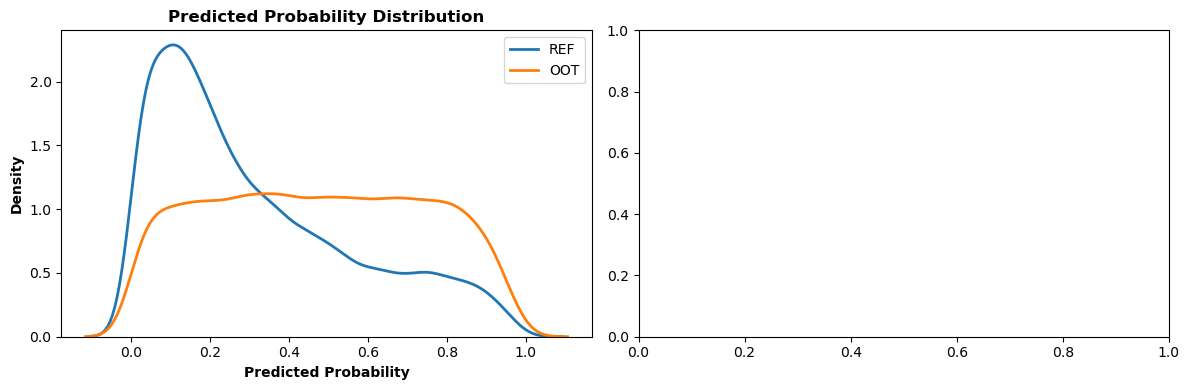

In [31]:
# … everything up to step 11 is unchanged …

# 12) Distribution Comparison – both on left KDE, and side-by-side bars on right
bins = np.linspace(0,1,11)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# --- LEFT: overlaid REF vs OOT density
sns.kdeplot(probs_ref, ax=ax1, label="REF", color="C0", linewidth=2)
sns.kdeplot(probs_oot, ax=ax1, label="OOT", color="C1", linewidth=2)
ax1.set_title("Predicted Probability Distribution", weight="bold")
ax1.set_xlabel("Predicted Probability", weight="bold")
ax1.set_ylabel("Density", weight="bold")
ax1.legend()

plt.tight_layout()
plt.show()

/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/4141028578.py:78: UserWarning: [00:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  art      = pickle.load(f)
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/

OOT ROC AUC: 0.6906
Overall PSI (REF→OOT): 0.3744


/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-

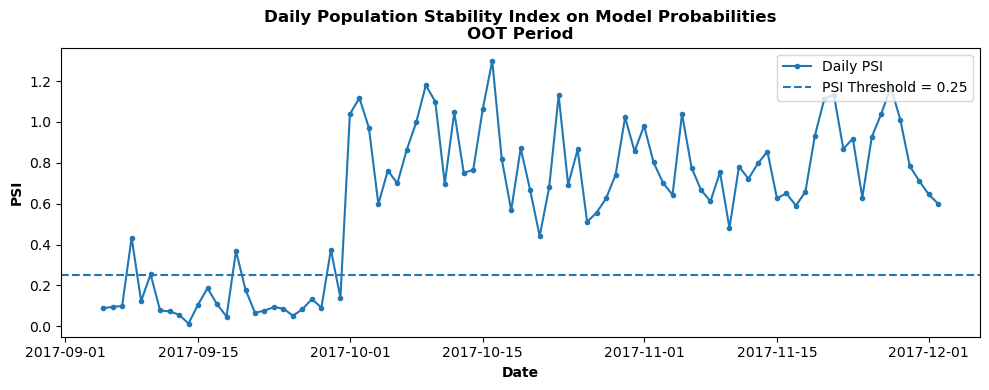

In [3]:
# === Notebook Cell: Prediction-Drift Monitoring via PSI (encoder fitted globally) ===

import glob, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

# 1) CONFIG
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
label_folder = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/label_store"
model_pkl    = "/Users/paulineng/MLE_grp10/scripts/model_bank/xgb_2017_12_04.pkl"

ref_start, ref_end = datetime(2016,9,4), datetime(2017,9,4)
oot_start, oot_end = datetime(2017,9,5), datetime(2017,12,3)

# 2) Load & tag snapshot_date
def load_gold(folder):
    parts = []
    for path in sorted(glob.glob(f"{folder}/*.parquet")):
        fn = path.rsplit("/",1)[-1]
        m  = re.search(r"(\d{4}_\d{2}_\d{2})", fn)
        if not m: continue
        dt = datetime.strptime(m.group(1), "%Y_%m_%d")
        df = pd.read_parquet(path)
        df["snapshot_date"] = dt
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

features = load_gold(feat_folder)
labels   = load_gold(label_folder)

# 3) Identify label column
lbl_cols = [c for c in labels.columns if c not in ("order_id","snapshot_date")]
assert len(lbl_cols)==1, f"Expected one label, got {lbl_cols}"
label_col = lbl_cols[0]

# 4) Split REF / OOT
feat_ref = features[(features.snapshot_date >= ref_start) & (features.snapshot_date <= ref_end)]
feat_oot = features[(features.snapshot_date >= oot_start) & (features.snapshot_date <= oot_end)]
lab_ref  = labels  [(labels.snapshot_date    >= ref_start) & (labels.snapshot_date    <= ref_end)]
lab_oot  = labels  [(labels.snapshot_date    >= oot_start) & (labels.snapshot_date    <= oot_end)]

# 5) Fit OHE on full seasons so both splits get same columns
season_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
season_ohe.fit(features[["season"]])
ohe_cols = season_ohe.get_feature_names_out(["season"])

# 6) Prepare function that merges, drops and applies the GLOBAL encoder
def prepare(df_feat, df_lab):
    df = df_feat.merge(
        df_lab[["order_id","snapshot_date", label_col]],
        on=["order_id","snapshot_date"], how="inner"
    )
    to_drop = [
        "avg_delay_rate","concentration","act_days_to_deliver",
        "total_freight_value","avg_processing_time",
        "same_state","total_volume_cm3","seller_city","seller_state",
        "order_status", label_col
    ]
    X = df.drop(columns=to_drop, errors="ignore").reset_index(drop=True)
    y = df[label_col].astype(int).reset_index(drop=True)
    # Encode season
    S = season_ohe.transform(X[["season"]])
    X = pd.concat([
        X.drop(columns=["season"]),
        pd.DataFrame(S, columns=ohe_cols, index=X.index)
    ], axis=1)
    return X, y

X_ref, y_ref = prepare(feat_ref, lab_ref)
X_oot, y_oot = prepare(feat_oot, lab_oot)

# 7) Load model, scaler, threshold
with open(model_pkl, 'rb') as f:
    art      = pickle.load(f)
model     = art["model"]
scaler    = art["preprocessing_transformers"]["stdscaler"]
threshold = art.get("threshold", 0.25)  # default to 0.25 if missing

# 8) Force exact feature order
feature_cols = [
    "total_qty","total_price","total_weight_g","total_density",
    "delivery_distance","same_city","is_weekend","avg_rating",
    "day_of_week","season_Spring","season_Summer","season_Winter"
]
X_ref = X_ref[feature_cols]
X_oot = X_oot[feature_cols]
assert X_ref.shape[1] == scaler.n_features_in_, (
    f"Scaler expects {scaler.n_features_in_}, got {X_ref.shape[1]}"
)

# 9) Predict probabilities
probs_ref = model.predict_proba(scaler.transform(X_ref))[:,1]
probs_oot = model.predict_proba(scaler.transform(X_oot))[:,1]

# 10) Compute and print OOT ROC AUC
print(f"OOT ROC AUC: {roc_auc_score(y_oot, probs_oot):.4f}")

# 11) Overall PSI on model probabilities
def psi(ref, cur, bins=10):
    edges = np.linspace(ref.min(), ref.max(), bins+1)
    counts_ref, _ = np.histogram(ref, bins=edges)
    counts_cur, _ = np.histogram(cur, bins=edges)
    p_ref = counts_ref / counts_ref.sum()
    p_cur = counts_cur / counts_cur.sum()
    # avoid zeros
    p_ref[p_ref == 0] = 1e-8
    p_cur[p_cur == 0] = 1e-8
    return np.sum((p_ref - p_cur) * np.log(p_ref / p_cur))

print(f"Overall PSI (REF→OOT): {psi(probs_ref, probs_oot):.4f}")

# 12) Daily PSI: compute for each day in OOT
import numpy as np  # ensure numpy is available

daily_dates = pd.date_range(oot_start, oot_end)
daily_psi   = []
for d in daily_dates:
    df_feat_day = feat_oot[feat_oot.snapshot_date == d]
    df_lab_day  = lab_oot[lab_oot.snapshot_date  == d]
    if df_feat_day.empty:
        daily_psi.append(np.nan)
    else:
        X_day, _ = prepare(df_feat_day, df_lab_day)
        X_day = X_day[feature_cols]
        probs_day = model.predict_proba(scaler.transform(X_day))[:,1]
        daily_psi.append(psi(probs_ref, probs_day))

# 13) Plot daily PSI with threshold line
plt.figure(figsize=(10,4))
plt.plot(daily_dates, daily_psi, marker='o', ms=3, label='Daily PSI')
plt.axhline(0.25, linestyle='--', label='PSI Threshold = 0.25')
plt.title("Daily Population Stability Index on Model Probabilities\nOOT Period", weight='bold')
plt.xlabel("Date", weight='bold')
plt.ylabel("PSI", weight='bold')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-

OOT ROC AUC: 0.6906
Overall PSI (REF→OOT) on probs: 0.3744


/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-

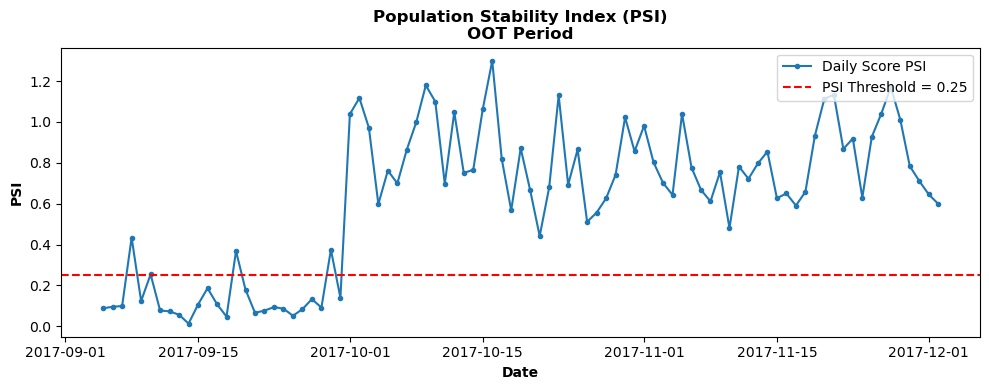

/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/MLE/lib/python3.10/site-

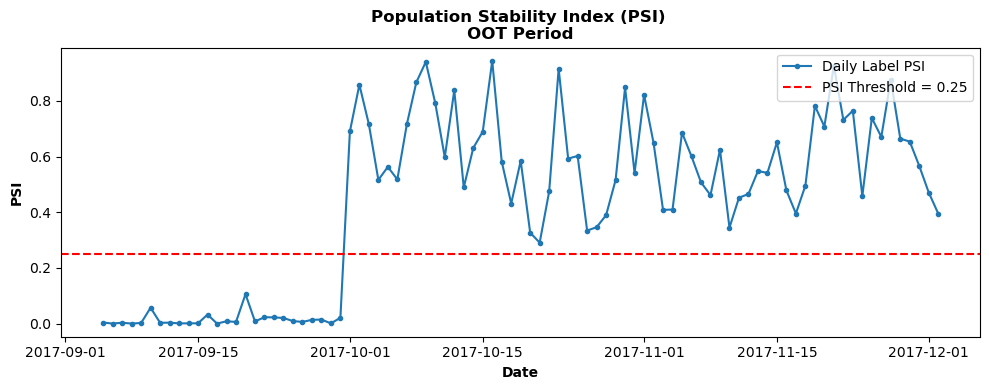

In [31]:
# === Notebook Cell: Prediction-Drift Monitoring via PSI (encoder fitted globally) ===

import glob, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

# 1) CONFIG
feat_folder  = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/feature_store"
label_folder = "/Users/paulineng/MLE_grp10/scripts/datamart/gold/label_store"
model_pkl    = "/Users/paulineng/MLE_grp10/scripts/model_bank/xgb_2017_12_04.pkl"

ref_start, ref_end = datetime(2016, 9, 4),  datetime(2017, 9, 4)
oot_start, oot_end = datetime(2017, 9, 5),  datetime(2017, 12, 3)

# 2) Load & tag snapshot_date
def load_gold(folder):
    parts = []
    for path in sorted(glob.glob(f"{folder}/*.parquet")):
        fn = path.rsplit("/", 1)[-1]
        m  = re.search(r"(\d{4}_\d{2}_\d{2})", fn)
        if not m: 
            continue
        dt = datetime.strptime(m.group(1), "%Y_%m_%d")
        df = pd.read_parquet(path)
        df["snapshot_date"] = dt
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

features = load_gold(feat_folder)
labels   = load_gold(label_folder)

# 3) Identify label column
lbl_cols = [c for c in labels.columns if c not in ("order_id","snapshot_date")]
assert len(lbl_cols) == 1, f"Expected one label, got {lbl_cols}"
label_col = lbl_cols[0]

# 4) Split REF / OOT
feat_ref = features[(features.snapshot_date >= ref_start) & (features.snapshot_date <= ref_end)]
feat_oot = features[(features.snapshot_date >= oot_start) & (features.snapshot_date <= oot_end)]
lab_ref  = labels  [(labels.snapshot_date   >= ref_start) & (labels.snapshot_date   <= ref_end)]
lab_oot  = labels  [(labels.snapshot_date   >= oot_start) & (labels.snapshot_date   <= oot_end)]

# 5) Fit OHE on full seasons so both splits get same columns
season_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
season_ohe.fit(features[["season"]])
ohe_cols = season_ohe.get_feature_names_out(["season"])

# 6) Prepare function that merges, drops and applies the GLOBAL encoder
def prepare(df_feat, df_lab):
    df = df_feat.merge(
        df_lab[["order_id","snapshot_date", label_col]],
        on=["order_id","snapshot_date"], how="inner"
    )
    to_drop = [
      "avg_delay_rate","concentration","act_days_to_deliver",
      "total_freight_value","avg_processing_time",
      "same_state","total_volume_cm3","seller_city","seller_state",
      "order_status", label_col
    ]
    X = df.drop(columns=to_drop, errors="ignore").reset_index(drop=True)
    y = df[label_col].astype(int).reset_index(drop=True)

    # transform season with the GLOBAL encoder
    S = season_ohe.transform(X[["season"]])
    X = pd.concat([
        X.drop(columns=["season"]),
        pd.DataFrame(S, columns=ohe_cols, index=X.index)
    ], axis=1)
    return X, y

X_ref, y_ref = prepare(feat_ref, lab_ref)
X_oot, y_oot = prepare(feat_oot, lab_oot)

# 7) Load model & scaler & stored threshold
with open(model_pkl, 'rb') as f:
    art      = pickle.load(f)
model       = art["model"]
scaler      = art["preprocessing_transformers"]["stdscaler"]
threshold   = art.get("threshold", 0.25)  # fallback to 0.25 if not present

# 8) Force exact 12-feature order
feature_cols = [
    "total_qty","total_price","total_weight_g","total_density",
    "delivery_distance","same_city","is_weekend","avg_rating",
    "day_of_week","season_Spring","season_Summer","season_Winter"
]
X_ref = X_ref[feature_cols]
X_oot = X_oot[feature_cols]

assert X_ref.shape[1] == scaler.n_features_in_, \
       f"Scaler expects {scaler.n_features_in_}, got {X_ref.shape[1]}"

# 9) Predict probabilities
probs_ref = model.predict_proba(scaler.transform(X_ref))[:, 1]
probs_oot = model.predict_proba(scaler.transform(X_oot))[:, 1]

# 10) ROC AUC on OOT
print(f"OOT ROC AUC: {roc_auc_score(y_oot, probs_oot):.4f}")

# 11) PSI function (uses raw proportions, not density)
def psi(ref, cur, bins=10):
    edges = np.linspace(ref.min(), ref.max(), bins + 1)
    c1, _ = np.histogram(ref, edges)
    c2, _ = np.histogram(cur, edges)
    p1 = c1 / c1.sum()
    p2 = c2 / c2.sum()
    p1[p1 == 0] = 1e-8
    p2[p2 == 0] = 1e-8
    return np.sum((p1 - p2) * np.log(p1 / p2))

# 12) Overall PSI on probabilities
print(f"Overall PSI (REF→OOT) on probs: {psi(probs_ref, probs_oot):.4f}")

# 13) Daily PSI on probabilities (score-drift)
daily_dates       = pd.date_range(oot_start, oot_end)
daily_score_psi   = []

for d in daily_dates:
    df_f_day = feat_oot[feat_oot.snapshot_date == d]
    df_l_day = lab_oot [lab_oot.snapshot_date   == d]
    if df_f_day.empty:
        daily_score_psi.append(np.nan)
    else:
        X_day, _    = prepare(df_f_day, df_l_day)
        X_day       = X_day[feature_cols]
        probs_day   = model.predict_proba(scaler.transform(X_day))[:, 1]
        daily_score_psi.append(psi(probs_ref, probs_day))

plt.figure(figsize=(10,4))
plt.plot(daily_dates, daily_score_psi, marker='o', ms=3, label='Daily Score PSI')
plt.axhline(0.25, color='red', ls='--', label='PSI Threshold = 0.25')
plt.title("Population Stability Index (PSI)\nOOT Period", weight='bold')
plt.xlabel("Date", weight='bold'); plt.ylabel("PSI", weight='bold')
plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

# 14) Daily PSI on 0/1 decisions (label-drift at threshold)
labels_ref = (probs_ref >= threshold).astype(int)
daily_label_psi = []

for d in daily_dates:
    df_f_day = feat_oot[feat_oot.snapshot_date == d]
    df_l_day = lab_oot [lab_oot.snapshot_date   == d]
    if df_f_day.empty:
        daily_label_psi.append(np.nan)
    else:
        X_day, _    = prepare(df_f_day, df_l_day)
        X_day       = X_day[feature_cols]
        probs_day   = model.predict_proba(scaler.transform(X_day))[:, 1]
        labels_day  = (probs_day >= threshold).astype(int)
        daily_label_psi.append(psi(labels_ref, labels_day, bins=2))

plt.figure(figsize=(10,4))
plt.plot(daily_dates, daily_label_psi, marker='o', ms=3, label='Daily Label PSI')
plt.axhline(0.25, color='red', ls='--', label='PSI Threshold = 0.25')
plt.title("Population Stability Index (PSI) \nOOT Period", weight='bold')
plt.xlabel("Date", weight='bold'); plt.ylabel("PSI", weight='bold')
plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

In [45]:
# === Notebook Cell: Monthly Late Delivery Metrics with Date Ranges ===

import pandas as pd
from pandas.tseries.offsets import MonthEnd

# 1) Path to your CSV file
file_path = '/Users/paulineng/Desktop/Olist Project/olist_orders_dataset.csv'  # update as needed

# 2) Load the data
df = pd.read_csv(
    file_path,
    parse_dates=['order_purchase_timestamp', 'order_delivered_customer_date'],
    infer_datetime_format=True
).dropna(subset=['order_delivered_customer_date'])

# 3) Compute “late” flag (>14 days from purchase → customer delivery)
df['delivery_delay'] = (df['order_delivered_customer_date'] - 
                        df['order_purchase_timestamp']).dt.days
df['late'] = df['delivery_delay'] > 14

# 4) Filter to Sep 2016 – Dec 2017 by purchase date
mask = (
    (df['order_purchase_timestamp'] >= '2016-09-01') &
    (df['order_purchase_timestamp'] <= '2017-11-30')
)
df_period = df.loc[mask].copy()

# 5) Extract calendar month (first day of month)
df_period['month'] = (
    df_period['order_purchase_timestamp']
      .dt.to_period('M')
      .dt.to_timestamp()
)

# 6) Aggregate counts and percentages
monthly = (
    df_period
      .groupby('month')
      .agg(
        total_orders=('order_id','count'),
        late_orders =('late','sum')
      )
      .reset_index()
)
monthly['percent_late'] = (monthly['late_orders'] / 
                           monthly['total_orders'] * 100).round(2)

# 7) Add explicit start/end dates for each month
monthly['period_start'] = monthly['month']
monthly['period_end']   = monthly['month'] + MonthEnd(1)
monthly['date_range']   = (
    monthly['period_start'].dt.strftime('%Y-%m-%d')
    + ' to ' +
    monthly['period_end'].dt.strftime('%Y-%m-%d')
)

# 8) Print as markdown-style table with date ranges
print(
    monthly
      .loc[:, ['date_range','total_orders','late_orders','percent_late']]
      .rename(columns={'date_range':'Month Range',
                       'total_orders':'Total Orders',
                       'late_orders':'Late Orders',
                       'percent_late':'% Late'})
      .to_markdown(index=False)
)

/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/1784034076.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/1784034076.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/1784034076.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


| Month Range              |   Total Orders |   Late Orders |   % Late |
|:-------------------------|---------------:|--------------:|---------:|
| 2016-09-01 to 2016-09-30 |              1 |             1 |   100    |
| 2016-10-01 to 2016-10-31 |            270 |           153 |    56.67 |
| 2016-12-01 to 2016-12-31 |              1 |             0 |     0    |
| 2017-01-01 to 2017-01-31 |            750 |           161 |    21.47 |
| 2017-02-01 to 2017-02-28 |           1653 |           460 |    27.83 |
| 2017-03-01 to 2017-03-31 |           2546 |           592 |    23.25 |
| 2017-04-01 to 2017-04-30 |           2303 |           866 |    37.6  |
| 2017-05-01 to 2017-05-31 |           3545 |           723 |    20.39 |
| 2017-06-01 to 2017-06-30 |           3135 |           716 |    22.84 |
| 2017-07-01 to 2017-07-31 |           3872 |           878 |    22.68 |
| 2017-08-01 to 2017-08-31 |           4193 |           914 |    21.8  |
| 2017-09-01 to 2017-09-30 |           4150 |      

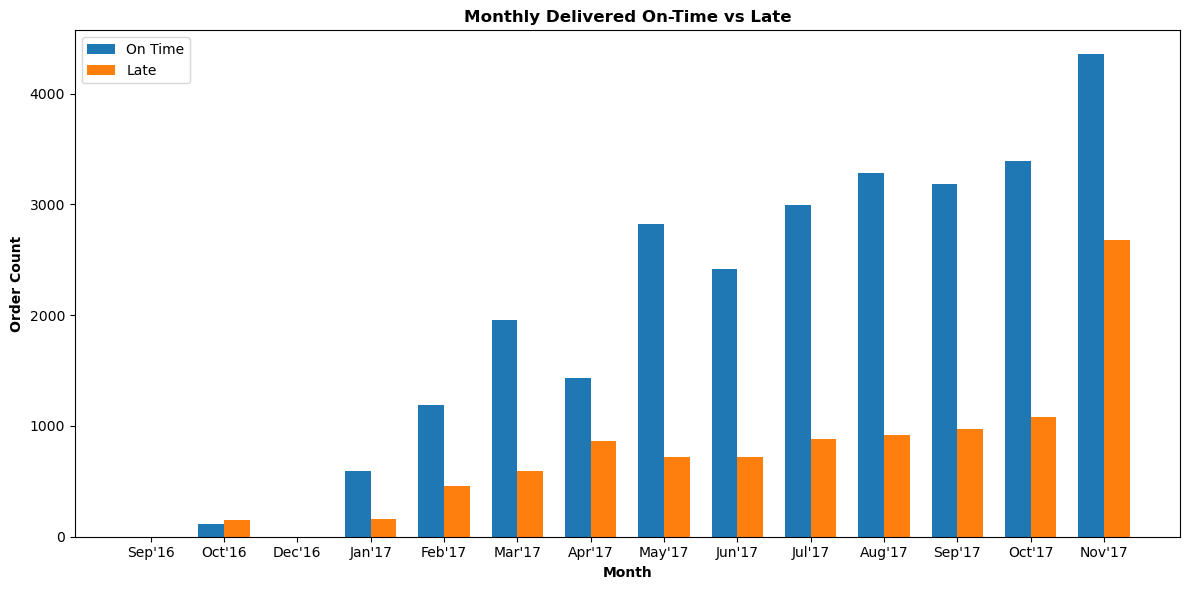

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Prepare
monthly['on_time'] = monthly['total_orders'] - monthly['late_orders']
months = monthly['month']
x = np.arange(len(months))
width = 0.35

# Plot grouped bars
plt.figure(figsize=(12,6))
plt.bar(x - width/2, monthly['on_time'],  width, label='On Time')
plt.bar(x + width/2, monthly['late_orders'], width, label='Late')

# Formatting
plt.title('Monthly Delivered On-Time vs Late', weight='bold')
plt.xlabel('Month', weight='bold')
plt.ylabel('Order Count', weight='bold')

# Horizontal, abbreviated tick labels like Sep'16
tick_labels = [m.strftime("%b'%y") for m in months]  # e.g. "Sep'16"
plt.xticks(x, tick_labels, rotation=0)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
# === Notebook Cell: Monthly Late Delivery Metrics Including Empty Months ===

import pandas as pd
from pandas.tseries.offsets import MonthEnd

# 1) Path to your CSV file
file_path = '/Users/paulineng/Desktop/Olist Project/olist_orders_dataset.csv'  # update as needed

# 2) Load the data and drop rows missing a delivery date
df = pd.read_csv(
    file_path,
    parse_dates=['order_purchase_timestamp', 'order_delivered_customer_date'],
    infer_datetime_format=True
).dropna(subset=['order_delivered_customer_date'])

# 3) Compute “late” flag (>14 days from purchase → customer delivery)
df['delivery_delay'] = (df['order_delivered_customer_date'] -
                        df['order_purchase_timestamp']).dt.days
df['late'] = df['delivery_delay'] > 14

# 4) Filter to Sep 2016 – Dec 2017 by purchase date
mask = (
    (df['order_purchase_timestamp'] >= '2016-09-01') &
    (df['order_purchase_timestamp'] <= '2018-8-31')
)
df_period = df.loc[mask].copy()

# 5) Extract calendar month (first day of month)
df_period['month'] = (
    df_period['order_purchase_timestamp']
      .dt.to_period('M')
      .dt.to_timestamp()
)

# 6) Aggregate counts per month
monthly = (
    df_period
      .groupby('month')
      .agg(
          total_orders = ('order_id', 'count'),
          late_orders  = ('late',     'sum')
      )
      .reset_index()
)

# 7) Ensure all months appear (fill missing with zeros)
all_months = pd.date_range(
    start='2016-09-01',
    end  ='2018-8-31',
    freq ='MS'      # Month start frequency
)
monthly_full = (
    monthly
      .set_index('month')
      .reindex(all_months, fill_value=0)
      .rename_axis('month')
      .reset_index()
)

# 8) Compute percent late safely (avoid div by zero)
monthly_full['percent_late'] = (
    monthly_full['late_orders'] /
    monthly_full['total_orders'].replace(0, 1)
    * 100
).round(2)

# 9) Add date-range strings
monthly_full['period_start'] = monthly_full['month']
monthly_full['period_end']   = monthly_full['month'] + MonthEnd(1)
monthly_full['Month Range'] = (
    monthly_full['period_start'].dt.strftime('%Y-%m-%d')
    + ' to '
    + monthly_full['period_end'].dt.strftime('%Y-%m-%d')
)

# 10) Print the final table
print(
    monthly_full
      .loc[:, ['Month Range', 'total_orders', 'late_orders', 'percent_late']]
      .rename(columns={
         'total_orders':'Total Orders',
         'late_orders' :'Late Orders',
         'percent_late':'% Late'
      })
      .to_markdown(index=False)
)

/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/2834275457.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/2834275457.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/2834275457.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


| Month Range              |   Total Orders |   Late Orders |   % Late |
|:-------------------------|---------------:|--------------:|---------:|
| 2016-09-01 to 2016-09-30 |              1 |             1 |   100    |
| 2016-10-01 to 2016-10-31 |            270 |           153 |    56.67 |
| 2016-11-01 to 2016-11-30 |              0 |             0 |     0    |
| 2016-12-01 to 2016-12-31 |              1 |             0 |     0    |
| 2017-01-01 to 2017-01-31 |            750 |           161 |    21.47 |
| 2017-02-01 to 2017-02-28 |           1653 |           460 |    27.83 |
| 2017-03-01 to 2017-03-31 |           2546 |           592 |    23.25 |
| 2017-04-01 to 2017-04-30 |           2303 |           866 |    37.6  |
| 2017-05-01 to 2017-05-31 |           3545 |           723 |    20.39 |
| 2017-06-01 to 2017-06-30 |           3135 |           716 |    22.84 |
| 2017-07-01 to 2017-07-31 |           3872 |           878 |    22.68 |
| 2017-08-01 to 2017-08-31 |           4193 |      

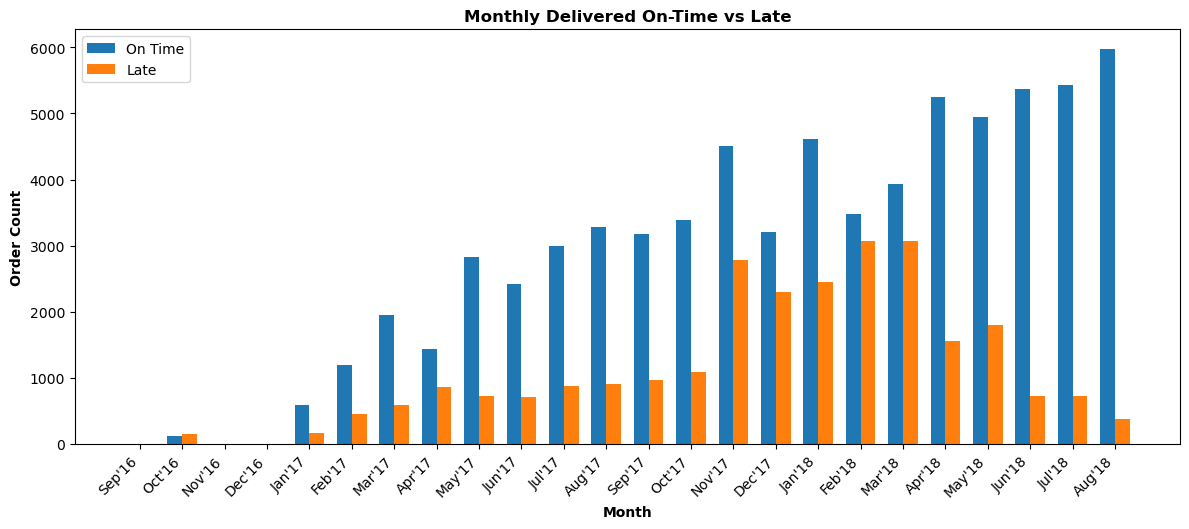

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# assume monthly_full has 'month', 'total_orders', 'late_orders' for Sep'16–Dec'17

# Compute on-time counts
monthly_full['on_time'] = monthly_full['total_orders'] - monthly_full['late_orders']

# Positions
x     = np.arange(len(monthly_full))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, monthly_full['on_time'],  width, label='On Time')
plt.bar(x + width/2, monthly_full['late_orders'], width, label='Late')

plt.title('Monthly Delivered On-Time vs Late', weight='bold')
plt.xlabel('Month', weight='bold')
plt.ylabel('Order Count', weight='bold')

# xticks: rotate 45°, right-align, and add bottom margin
tick_labels = [d.strftime("%b'%y") for d in monthly_full['month']]
plt.xticks(x, tick_labels, rotation=45, ha='right')

plt.legend(loc='upper left')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # give space for rotated labels
plt.show()

In [48]:
# === Notebook Cell: Monthly Late Delivery Metrics Including Empty Months ===

import pandas as pd
from pandas.tseries.offsets import MonthEnd

# 1) Path to your CSV file
file_path = '/Users/paulineng/Desktop/Olist Project/olist_orders_dataset.csv'  # update as needed

# 2) Load the data and drop rows missing a delivery date
df = pd.read_csv(
    file_path,
    parse_dates=['order_purchase_timestamp', 'order_delivered_customer_date'],
    infer_datetime_format=True
).dropna(subset=['order_delivered_customer_date'])

# 3) Compute “late” flag (>14 days from purchase → customer delivery)
df['delivery_delay'] = (df['order_delivered_customer_date'] -
                        df['order_purchase_timestamp']).dt.days
df['late'] = df['delivery_delay'] > 14

# 4) Filter to Sep 2016 – Dec 2017 by purchase date
mask = (
    (df['order_purchase_timestamp'] >= '2016-09-01') &
    (df['order_purchase_timestamp'] <= '2017-11-30')
)
df_period = df.loc[mask].copy()

# 5) Extract calendar month (first day of month)
df_period['month'] = (
    df_period['order_purchase_timestamp']
      .dt.to_period('M')
      .dt.to_timestamp()
)

# 6) Aggregate counts per month
monthly = (
    df_period
      .groupby('month')
      .agg(
          total_orders = ('order_id', 'count'),
          late_orders  = ('late',     'sum')
      )
      .reset_index()
)

# 7) Ensure all months appear (fill missing with zeros)
all_months = pd.date_range(
    start='2016-09-01',
    end  ='2017-11-30',
    freq ='MS'      # Month start frequency
)
monthly_full = (
    monthly
      .set_index('month')
      .reindex(all_months, fill_value=0)
      .rename_axis('month')
      .reset_index()
)

# 8) Compute percent late safely (avoid div by zero)
monthly_full['percent_late'] = (
    monthly_full['late_orders'] /
    monthly_full['total_orders'].replace(0, 1)
    * 100
).round(2)

# 9) Add date-range strings
monthly_full['period_start'] = monthly_full['month']
monthly_full['period_end']   = monthly_full['month'] + MonthEnd(1)
monthly_full['Month Range'] = (
    monthly_full['period_start'].dt.strftime('%Y-%m-%d')
    + ' to '
    + monthly_full['period_end'].dt.strftime('%Y-%m-%d')
)

# 10) Print the final table
print(
    monthly_full
      .loc[:, ['Month Range', 'total_orders', 'late_orders', 'percent_late']]
      .rename(columns={
         'total_orders':'Total Orders',
         'late_orders' :'Late Orders',
         'percent_late':'% Late'
      })
      .to_markdown(index=False)
)

/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/3439102887.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/3439102887.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/var/folders/28/58wf6pkn42zbxx3c6501tnnh0000gn/T/ipykernel_71351/3439102887.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


| Month Range              |   Total Orders |   Late Orders |   % Late |
|:-------------------------|---------------:|--------------:|---------:|
| 2016-09-01 to 2016-09-30 |              1 |             1 |   100    |
| 2016-10-01 to 2016-10-31 |            270 |           153 |    56.67 |
| 2016-11-01 to 2016-11-30 |              0 |             0 |     0    |
| 2016-12-01 to 2016-12-31 |              1 |             0 |     0    |
| 2017-01-01 to 2017-01-31 |            750 |           161 |    21.47 |
| 2017-02-01 to 2017-02-28 |           1653 |           460 |    27.83 |
| 2017-03-01 to 2017-03-31 |           2546 |           592 |    23.25 |
| 2017-04-01 to 2017-04-30 |           2303 |           866 |    37.6  |
| 2017-05-01 to 2017-05-31 |           3545 |           723 |    20.39 |
| 2017-06-01 to 2017-06-30 |           3135 |           716 |    22.84 |
| 2017-07-01 to 2017-07-31 |           3872 |           878 |    22.68 |
| 2017-08-01 to 2017-08-31 |           4193 |      

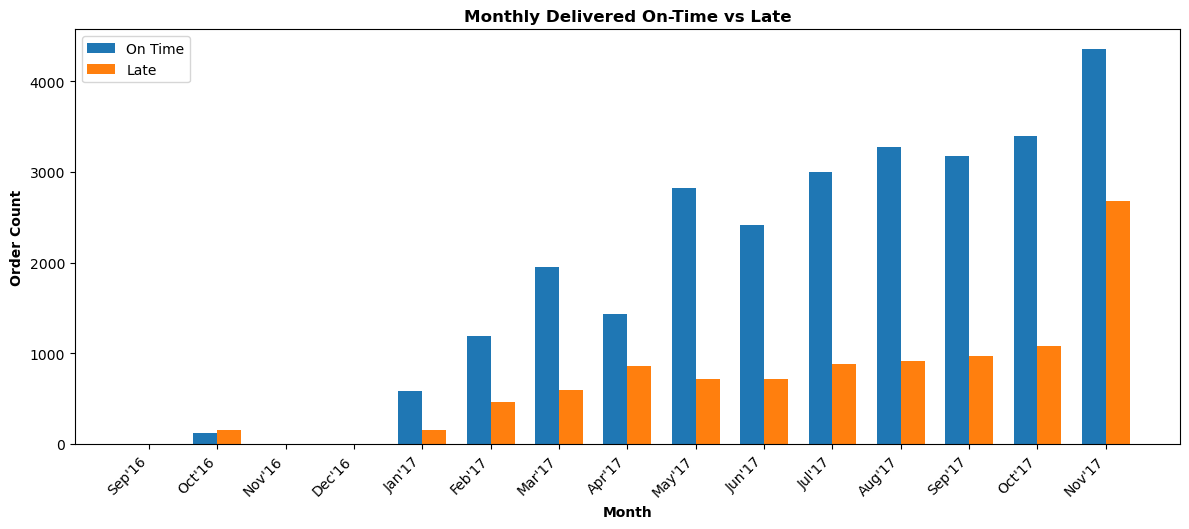

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# assume monthly_full has 'month', 'total_orders', 'late_orders' for Sep'16–Dec'17

# Compute on-time counts
monthly_full['on_time'] = monthly_full['total_orders'] - monthly_full['late_orders']

# Positions
x     = np.arange(len(monthly_full))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, monthly_full['on_time'],  width, label='On Time')
plt.bar(x + width/2, monthly_full['late_orders'], width, label='Late')

plt.title('Monthly Delivered On-Time vs Late', weight='bold')
plt.xlabel('Month', weight='bold')
plt.ylabel('Order Count', weight='bold')

# xticks: rotate 45°, right-align, and add bottom margin
tick_labels = [d.strftime("%b'%y") for d in monthly_full['month']]
plt.xticks(x, tick_labels, rotation=45, ha='right')

plt.legend(loc='upper left')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # give space for rotated labels
plt.show()